In [1]:
import torch
from torch.distributions import StudentT,Normal,Laplace,Gamma, Bernoulli, Categorical
import matplotlib.pyplot as plt
from random import sample,seed
import seaborn as sns
from ssvkernel import ssvkernel

In [2]:
from causal_cocycle.model import cocycle_model,flow_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Constant_Conditioner, Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd
from causal_cocycle.kernels import *
from causal_cocycle.regression_functionals import *
from causal_cocycle.distribution_estimation import *

In [3]:
# Helper functions

class Rademacher:

    def __init__(self, p=0.5):
        self.p = p
        
    def sample(self, shape):
        Y = Bernoulli(self.p).sample(shape)
        return Y*2 -1

class likelihood_loss:
    
    def __init__(self,dist):
        self.dist = dist
        if hasattr(dist,'df'):
            self.parameters = self.dist.df.requires_grad_(True)
        else:
            self.parameters = torch.tensor(1.0)
        self.loss_fn = "MLE"
    
    def __call__(self,model,inputs,outputs):
        U,logdet = model.inverse_transformation(inputs,outputs)
        
        return torch.mean(-self.dist.log_prob(U) - logdet) 

def optimise_dynamic(model,
             loss,
             inputs,
             outputs, 
             loss_val = [],
             inputs_val = [],
             outputs_val = [],
             learn_rate = [1e-3], 
             maxiter = 10000,
             miniter = 10000, 
             weight_decay = 0,
            # optimise_loss_params = True, 
             val_loss = True, 
             val_loss_freq = 100,
             val_tol = 1e-3, 
             batch_size = 1024, 
             val_batch_size = 1024,
             batch_sampling = "random", 
             scheduler = False, 
             schedule_milestone = 100, 
             n_schedule = 100,
             lr_mult = 0.90, 
             plot = False, 
             plot_start = 30, 
             print_ = False, 
             optimise_conditioners = True, 
             likelihood_param_opt = False,
             likelihood_param_lr = 0.01):

    # Dimensions
    m = len(outputs)
    m_val = len(outputs_val)

    # Parameters set up
    conditioner_params_list = []
    if len(learn_rate)==1:
        learn_rate = learn_rate*len(model.conditioner)
    for k in range(len(model.conditioner)):
            if optimise_conditioners or (len(optimise_conditioners)>1 and optimise_conditioners[k]==True):
                    conditioner_params_list +=  [{'params' : model.conditioner[k].parameters(),
                                                                        'lr' : learn_rate[k]}]  
    if likelihood_param_opt:
         conditioner_params_list +=  [{'params' : [loss.parameters],
                                        'lr' : likelihood_param_lr}]  
    # Optimiser set up
    optimizer = torch.optim.Adam(conditioner_params_list,weight_decay = weight_decay)  
    if scheduler:
        lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                      step_size = schedule_milestone, 
                                                      gamma=lr_mult)
    batch_start,batch_end = 0,batch_size

    # Optimisation iterations
    Losses = torch.zeros(maxiter)
    Losses_val = torch.zeros(maxiter)
    i = 0 # iter counter
    
    while i < maxiter:
        optimizer.zero_grad()

        #Subsampling
        if batch_size < m and batch_sampling == "random":
            inputs_batch,outputs_batch = get_subsample(inputs,
                                                       outputs,
                                                       batch_size)
        elif batch_size < m:
            if batch_end < m:
                batch_start += batch_size
                batch_end += batch_size
            else:
                batch_start,batch_end = 0,batch_size
            if batch_end > m:
                batch_end = m
            inputs_batch = inputs[batch_start:batch_end]
            outputs_batch = outputs[batch_start:batch_end]
        else:
            inputs_batch,outputs_batch = inputs,outputs

        # Training loss computation
        try:
            Loss = loss(model,inputs_batch,outputs_batch)
        except:
            print("Forward pass error: exiting training iterations")
            break    
        Losses[i] = Loss.detach()

        # Optimisation step
        Loss.backward()
        optimizer.step()
        if scheduler:
            lr_schedule.step()

        # Display
        if print_ or plot:
            if not i % 10:
                clear_output(wait=True)
                if print_:
                    print("Training loss last 10 avg is :",Losses[i-10:i].mean())
                    print(100*i/maxiter," % completion")
                if plot and i > plot_start:
                    ytest = torch.linspace(-1,2,1000)[:,None]
                    plt.figure(figsize=(5, 4))
                    plt.plot(ytest,model.inverse_transformation(ytest,ytest)[0].detach())
                    plt.scatter(outputs,model.inverse_transformation(inputs,outputs)[0].detach())
                    plt.tight_layout()
                    display(plt.gcf())
        i += 1

    # Validation loss computation
    objs = []
    if val_loss and inputs_val != []:
        if loss_val == []:
            loss_val = loss
        with torch.no_grad():
            objs.append(loss_val(model,inputs_val[:val_batch_size],outputs_val[:val_batch_size]))
        
    return objs

In [4]:
# Experimental settings
n = 1000 # training samples
d = 1 # input dims
trials = 1 # experiment replications
ngrid = 100 # grid points for CATE
zlist = torch.linspace(-2,2,ngrid)[:,None]/d**0.5 # grid generation for CATE
a = torch.tensor([1.0]) # Int level
nu = 1 # DoF
sd = 1.0 # \sigma^2 on Y|X,Z
mc_samples = 10**5 # MC samples to approx expectations
hyper_ls = 2**torch.linspace(-2,2,5)
rng = 0
Dist = Bernoulli

# Interventions
intervention_hard = lambda a,x : a + x*0
intervention_shift = lambda a,x : a + x
intervention_scale = lambda a,x : a*x
interventions = [intervention_shift]

In [5]:
# Training set up
train_val_split = 1
ntrain = int(n)
learn_rate = [1e-3]
scheduler = False
val_tol = 1e-3
batch_size = 2
val_loss = False
maxiter = 5000
miniter = 5000
RQS_bins = 8
df_init = 10.0

# Model names
Models = ["True", "Parametric", "G-RQS SCM","L-RQS SCM"]

# Models
SCM_models = []

tail_adapt = [False,False,False,False]


grad = False

In [6]:
# Estimated CATEs
CATEs_param_est = torch.zeros(len(Models),len(interventions),trials,ngrid)
for t in range(trials):
    
    # Seed set
    seed(t+rng)
    torch.manual_seed(t+rng)
    
    # Getting sample data
    U = Dist(1/2).sample((n,1)).detach()
    if Dist == Bernoulli:
        Utrain = torch.tensor([[1.0],[0.0]])
    else:
        Utrain = torch.tensor([[1.0],[-1.0]])

    ## base distributions
    SCM_base_distributions = [
        Dist(0.5),
        Dist((U == U.max()).float().mean()),
        Normal(0,1),
        Laplace(0,1),
    ]
        
    # Transformers and conditioners
    SCM_conditioners = [
        [Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)],
        [Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)],
        [Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
    ]
    SCM_transformers = [
        Transformer([Scale_layer()],logdet = True),
        Transformer([Scale_layer()],logdet = True),
        Transformer([RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
        Transformer([RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
    ]
    
    # Model estimation
        
    # Getting input-output pairs
    inputs_train,outputs_train = Utrain,Utrain
    inputs_val,outputs_val = [],[]

    # SCM training
    for m in range(len(Models)):
        loss_fn = likelihood_loss(dist = SCM_base_distributions[m])
        model = flow_model(SCM_conditioners[m],SCM_transformers[m])
        if m > 1:
            model.transformer.logdet = True
            optimise_dynamic(model,
                          loss_fn,
                          inputs_train,
                          outputs_train,
                          inputs_val,
                          outputs_val, 
                          batch_size = batch_size,
                          learn_rate = learn_rate,
                          print_ = True,
                          plot = False, 
                          plot_start = 0,
                          miniter = miniter,
                          maxiter = maxiter, 
                          val_tol = val_tol,
                          val_loss = val_loss,
                          scheduler = scheduler,
                          likelihood_param_opt = True)
        model.transformer.logdet = False
        SCM_models.append(model)

        if tail_adapt[m]:
            SCM_base_distributions[m] = StudentT(SCM_base_distributions[m].df.detach(),0,1)
    
    print(t)

Training loss last 10 avg is : tensor(-5.8661)
99.8  % completion
0


tensor(-5.1452, grad_fn=<MeanBackward0>) tensor(-5.1452, grad_fn=<MeanBackward0>)


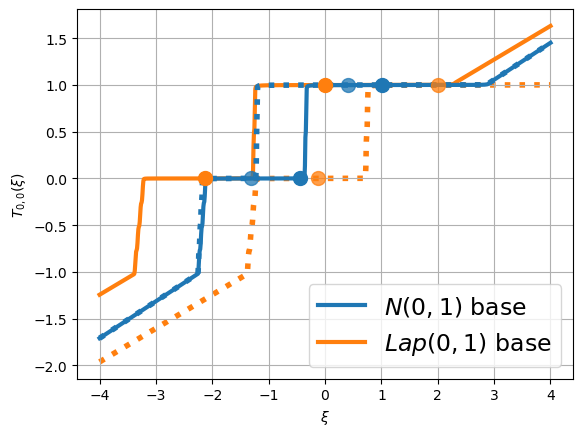

In [10]:
# Checking Gauss likelihood
Lik = likelihood_loss(Normal(0,1))
SCM_models[2].transformer.logdet = True

# Changing Gauss map
from copy import deepcopy
i = 7
width_shift = 0.8601
height_shift = 0
G_model = deepcopy(SCM_models[2])
G_model.conditioner[0].params = G_model.conditioner[0].params.detach()
G_model.conditioner[0].params[:,i] += width_shift
G_model.conditioner[0].params[:,i+RQS_bins] += height_shift
print(Lik(SCM_models[2],Utrain,Utrain),Lik(G_model,Utrain,Utrain))
SCM_models[2].transformer.logdet = False
G_model.transformer.logdet = False

# Plotting maps + transformed maps
ytest = torch.linspace(-4,4,1000)[:,None]
plt.plot(ytest,SCM_models[2].transformation(ytest,ytest).detach(), lw = 3, label = r"$N(0,1)$ base", color = "C0", alpha = 1.0, zorder = 11)
plt.plot(ytest,G_model.transformation(ytest,ytest).detach(), color = "C0", lw = 4.0, ls = "dotted", zorder = 10)
plt.plot(ytest,SCM_models[3].transformation(ytest,ytest).detach(), lw = 3, label = r"$Lap(0,1)$ base", color = "C1", alpha = 1.0)
plt.plot(ytest,SCM_models[3].transformation(ytest,ytest-2.0).detach(), lw = 4.0, ls = "dotted", color = "C1", zorder = 0)

plt.scatter(SCM_models[2].inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C0", zorder = 100, alpha = 1.0)
plt.scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C1", zorder = 100, alpha = 1.0)
plt.scatter(G_model.inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C0", zorder = 100, alpha = 0.75)
plt.scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach()+2.0,Utrain, s = 100, color = "C1", zorder = 100, alpha = 0.75)


plt.xlabel(r"$\xi$")
plt.ylabel(r"$T_{0,0}(\xi)$")
plt.legend(fontsize = 17)
plt.grid(zorder = 10)

In [23]:
X=  Normal(0,1).sample((mc_samples,1))
n = 1000
Y0pred = []
for m in range(len(Models)):
    basepred = SCM_base_distributions[m].sample((mc_samples,1))
    #Y0pred.append(torch.sigmoid(0.00*X+SCM_models[m].transformation(basepred,basepred).detach()-0.5) + 0.025*X)
    Y0pred.append(SCM_models[m].transformation(basepred,basepred).detach() + 0.05*X)
Y0pred.append(Y0pred[0][:n])

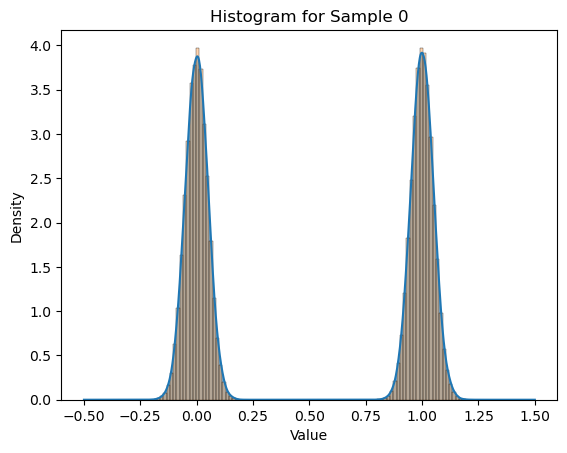

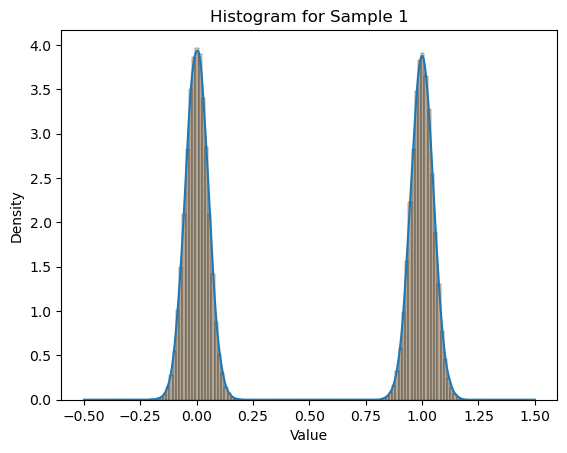

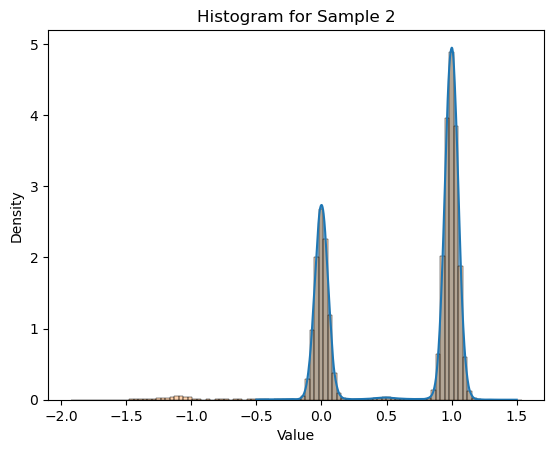

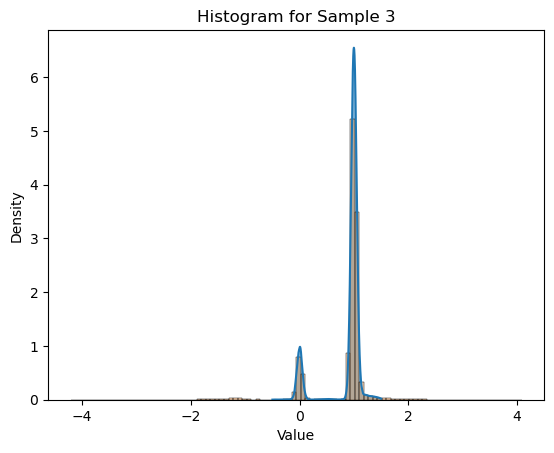

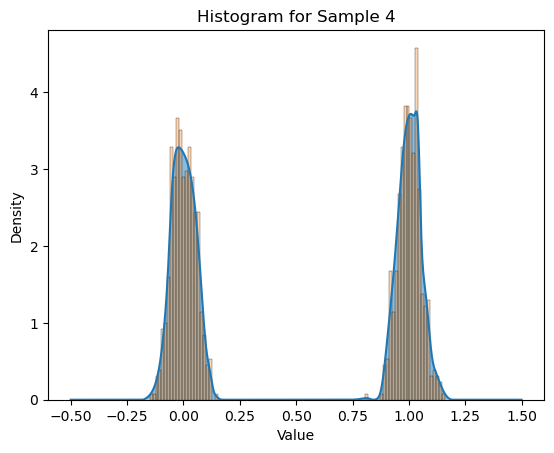

In [24]:
for i in range(5):
    data = Y0pred[i][:, 0].numpy()
    x = np.linspace(-0.5,1.5,1000)
    y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')
    plt.plot(x,y[0])
    plt.fill_between(x,0*y[0],y[0], alpha = 0.5)    
    sns.histplot(data, bins=100, alpha=0.33, stat = "density")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(f"Histogram for Sample {i}")
    plt.show()

In [10]:
import torch.nn.functional as F

def compute_rqs_bin_boundaries(
    unnormalized_widths, 
    unnormalized_heights,
    left=-1.0, 
    right=1.0, 
    bottom=-1.0, 
    top=1.0, 
    min_bin_width=1e-3,
    min_bin_height=1e-3
):
    """
    Replicates the bin-boundary logic in the RQS function (forward mode),
    returning the 'cumwidths' and 'cumheights' used for the piecewise spline.

    unnormalized_widths, unnormalized_heights: 1D tensors of shape [num_bins].
    left, right, bottom, top: float, domain/range boundaries used by RQS.
    min_bin_width, min_bin_height: minimal bin sizes as in your RQS code.

    Returns:
      cumwidths: shape [num_bins+1], the x-bin boundaries in [left, right].
      cumheights: shape [num_bins+1], the y-bin boundaries in [bottom, top].
    """
    num_bins = unnormalized_widths.shape[-1]

    # -- Widths --
    widths = F.softmax(unnormalized_widths, dim=-1)
    # Enforce minimum bin width
    widths = min_bin_width + (1 - min_bin_width*num_bins) * widths
    # Cumulative sum
    cumwidths = torch.cumsum(widths, dim=-1)
    # Pad a zero at the start
    cumwidths = F.pad(cumwidths, pad=(1,0), mode='constant', value=0.0)
    # Scale to [left, right]
    cumwidths = (right - left)*cumwidths + left
    # Force the very first boundary to be 'left' and the last to be 'right'
    cumwidths[0] = left
    cumwidths[-1] = right

    # -- Heights --
    heights = F.softmax(unnormalized_heights, dim=-1)
    # Enforce minimum bin height
    heights = min_bin_height + (1 - min_bin_height*num_bins) * heights
    # Cumulative sum
    cumheights = torch.cumsum(heights, dim=-1)
    cumheights = F.pad(cumheights, pad=(1,0), mode='constant', value=0.0)
    cumheights = (top - bottom)*cumheights + bottom
    # Force first boundary to 'bottom' and last to 'top'
    cumheights[0] = bottom
    cumheights[-1] = top

    return cumwidths, cumheights

In [11]:
shift = torch.log(1+torch.exp(SCM_models[2].conditioner[1].params))
scale = torch.log(1+torch.exp(SCM_models[2].conditioner[2].params))
print(shift,scale)

tensor([0.6308], grad_fn=<LogBackward0>) tensor([0.3953], grad_fn=<LogBackward0>)


tensor(-5.1452, grad_fn=<MeanBackward0>) tensor(-4.5673, grad_fn=<MeanBackward0>)
cumwidths: tensor([-2.2500, -0.9793, -0.9510, -0.9227, -0.8944,  0.4263,  0.4436,  0.4608,
         2.9000])
cumheights: tensor([-1.0000, -0.7519, -0.5038, -0.2557, -0.0076,  0.0076,  0.4833,  0.9590,
         1.0000])


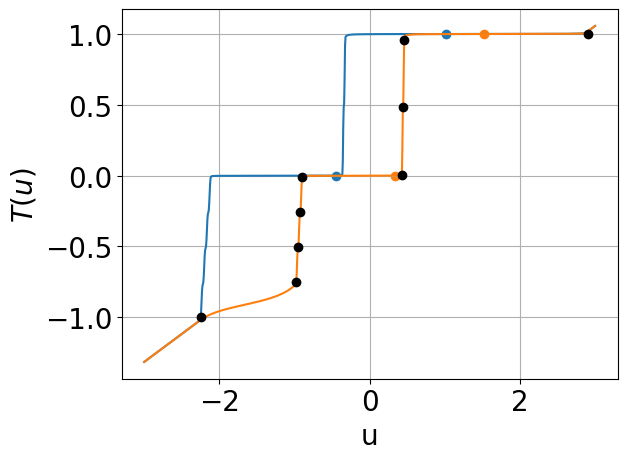

In [110]:
import torch.nn.functional as F

def compute_bin_boundaries(unnormalized, left, right, min_bin=1e-3):
    """
    Given a 1D torch tensor of unnormalized parameters (e.g. widths or heights),
    compute the normalized bin boundaries over the interval [left, right].
    """
    num_bins = unnormalized.shape[-1]
    # Apply softmax to get positive values that sum to 1
    normalized = F.softmax(unnormalized, dim=-1)
    # Enforce a minimal bin size
    normalized = min_bin + (1 - min_bin * num_bins) * normalized
    # Compute cumulative sum to get boundaries (starting at 0)
    cum = torch.cumsum(normalized, dim=-1)
    # Pad with a zero at the start
    cum = F.pad(cum, pad=(1, 0), mode='constant', value=0.0)
    # Scale to the interval [left, right]
    boundaries = (right - left) * cum + left
    return boundaries


i = 0
width_shift = 4
height_shift = 0
Lik = likelihood_loss(Normal(0,1))
ytest = torch.linspace(-3,3,1000)[:,None]
SCM_models[2].transformer.logdet = True
from copy import deepcopy
G_model = deepcopy(SCM_models[2])
G_model.conditioner[0].params = G_model.conditioner[0].params.detach()
G_model.conditioner[0].params[:,i] += width_shift
G_model.conditioner[0].params[:,i+RQS_bins] += height_shift
print(Lik(SCM_models[2],Utrain,Utrain),Lik(G_model,Utrain,Utrain))
SCM_models[2].transformer.logdet = False
G_model.transformer.logdet = False
plt.plot(ytest,SCM_models[2].transformation(ytest,ytest).detach())
plt.scatter(SCM_models[2].inverse_transformation(Utrain,Utrain).detach(),Utrain)
plt.plot(ytest,G_model.transformation(ytest,ytest).detach())
plt.scatter(G_model.inverse_transformation(Utrain,Utrain).detach(), Utrain)

#unnormalized widths and heights
unnormalized_widths =  SCM_models[2].conditioner[0].params[0,:RQS_bins].detach() + (torch.linspace(1,RQS_bins,RQS_bins)==i+1)*width_shift
unnormalized_heights =  SCM_models[2].conditioner[0].params[0,RQS_bins:2*RQS_bins].detach()

# Domain and range for the RQS
left, right = -2.25, 2.9
bottom, top = -1.0, 1.0

cumwidths, cumheights = compute_rqs_bin_boundaries(
    unnormalized_widths, 
    unnormalized_heights,
    left=left, 
    right=right,
    bottom=bottom, 
    top=top,
    min_bin_width=1e-3,
    min_bin_height=1e-3
)

print("cumwidths:", cumwidths)
print("cumheights:", cumheights)

# Plot just the intersection points
for (x,y) in zip(cumwidths,cumheights):
        plt.plot(x.item(), y.item(), 'ko')  # black circle marker

plt.xlabel("u")
plt.ylabel(r"$T(u)$")
plt.grid(True)
plt.show()

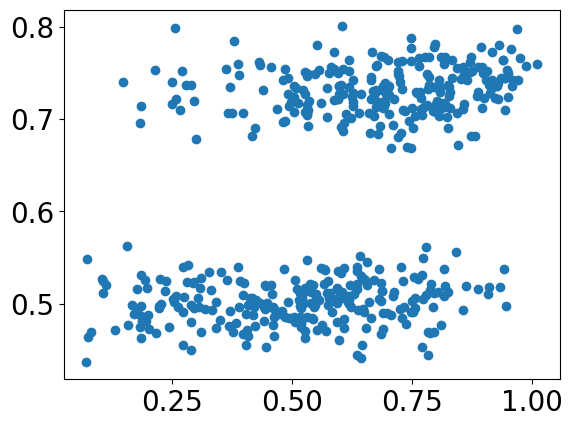

In [43]:
X = Normal(0,1).sample((n,1))
Z = Normal(0,1).sample((n,1))
Y,Y0 = torch.sigmoid(X+U) + 0.025*Z, torch.sigmoid(0.00*X + U) + 0.025*Z
plt.scatter(Y,Y0)

tensor(-5.1452, grad_fn=<MeanBackward0>) tensor(-5.1452, grad_fn=<MeanBackward0>)


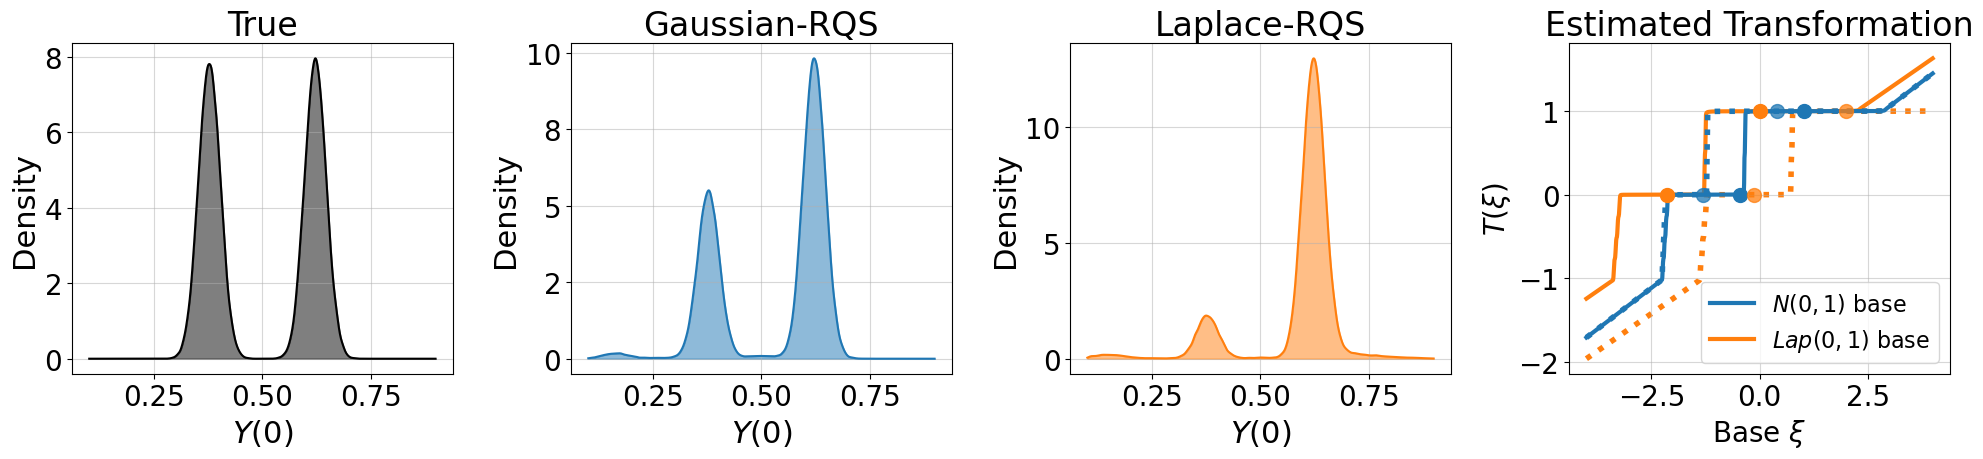

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
from ssvkernel import *
# Update rcParams for global font size settings
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})

plot_names = ["True", "Gaussian-RQS", "Laplace-RQS", "Tail-Adaptive-RQS"]
colours = ["black"] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_select = [0, 2, 3]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(len(model_select)):
    data = Y0pred[model_select[i]][:, 0].numpy()  # Assuming Y0pred is defined elsewhere
    x = np.linspace(0.1, 0.9, 1000)
    y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')  # Assuming ssvkernel is defined
    axs[i].plot(x, y[0], color=colours[i])
    axs[i].fill_between(x, 0 * y[0], y[0], alpha=0.5, color=colours[i])
    axs[i].set_xlabel(r"$Y(0)$", fontsize=22)
    axs[i].set_ylabel("Density", fontsize=22)
    axs[i].set_title(plot_names[i], fontsize=24)  # Assuming Models is defined
    axs[i].tick_params(axis='both', which='major', labelsize=20)

     # Set y-axis tick formatter to 0 decimal places
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Final plot of invariant transformations
Lik = likelihood_loss(Normal(0,1))
SCM_models[2].transformer.logdet = True

# Changing Gauss map
from copy import deepcopy
i = 7
width_shift = 0.8601
height_shift = 0
G_model = deepcopy(SCM_models[2])
G_model.conditioner[0].params = G_model.conditioner[0].params.detach()
G_model.conditioner[0].params[:,i] += width_shift
G_model.conditioner[0].params[:,i+RQS_bins] += height_shift
print(Lik(SCM_models[2],Utrain,Utrain),Lik(G_model,Utrain,Utrain))
SCM_models[2].transformer.logdet = False
G_model.transformer.logdet = False

# Plotting maps + transformed maps
axs[-1].set_title("Estimated Transformation")
ytest = torch.linspace(-4,4,1000)[:,None]
axs[-1].plot(ytest,SCM_models[2].transformation(ytest,ytest).detach(), lw = 3, label = r"$N(0,1)$ base", color = "C0", alpha = 1.0, zorder = 11)
axs[-1].plot(ytest,G_model.transformation(ytest,ytest).detach(), color = "C0", lw = 4.0, ls = "dotted", zorder = 10)
axs[-1].plot(ytest,SCM_models[3].transformation(ytest,ytest).detach(), lw = 3, label = r"$Lap(0,1)$ base", color = "C1", alpha = 1.0)
axs[-1].plot(ytest,SCM_models[3].transformation(ytest,ytest-2.0).detach(), lw = 4.0, ls = "dotted", color = "C1", zorder = 0)

axs[-1].scatter(SCM_models[2].inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C0", zorder = 100, alpha = 1.0)
axs[-1].scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C1", zorder = 100, alpha = 1.0)
axs[-1].scatter(G_model.inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C0", zorder = 100, alpha = 0.75)
axs[-1].scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach()+2.0,Utrain, s = 100, color = "C1", zorder = 100, alpha = 0.75)
axs[-1].legend(fontsize = 16)

axs[-1].set_xlabel(r"Base $\xi$")
axs[-1].set_ylabel(r"$T(\xi)$")
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)
axs[2].grid(alpha=0.5)
axs[-1].grid(alpha = 0.5)
fig.tight_layout()
fig.savefig("Discretemisspec_example", bbox_inches="tight")

In [35]:
print(KSDs)

tensor([[[0.0000]],

        [[0.0027]],

        [[0.1362]],

        [[0.3558]],

        [[0.0878]],

        [[0.0283]]])


In [33]:
# Interventional Distribution Construction + Evaluation
int_levels = torch.linspace(0,0,1)
t = 0
KSDs = torch.zeros((len(Models)+1,len(int_levels),trials))
Means = torch.zeros((len(Models)+1,len(int_levels),trials))
for i in range(len(int_levels)):

    # Int sampling
    Y0pred = []
    for m in range(len(Models)):
        basepred = SCM_base_distributions[m].sample((mc_samples,1))
        Y0pred.append(torch.sigmoid(SCM_models[m].transformation(basepred,basepred).detach()+int_levels[i] - 0.5)+0.025*X)
        Means[m,i,t] = Y0pred[m].mean()
    Y0pred.append(Y0pred[0][:n])
    Means[-1,i,t] = Y0pred[m].mean()

    # CDF Construction + Storage
    eps = torch.linspace(0,1,100)[None]
    cdfs = []
    for m in range(len(Models)+1):
        cdfs.append((Y0pred[m]<=eps).float().mean(0))
        KSDs[m,i,t] = (cdfs[0]-cdfs[m]).abs().max()

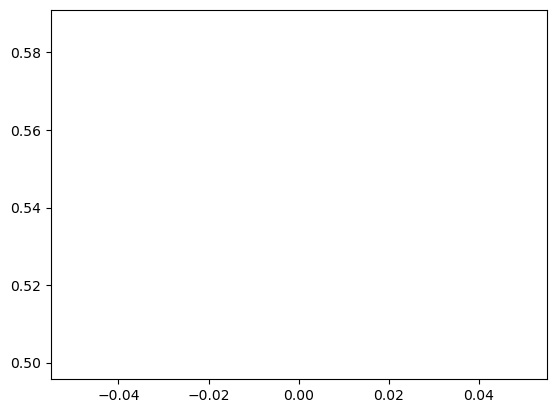

In [34]:
plt.plot(int_levels, Means[...,-1].T);

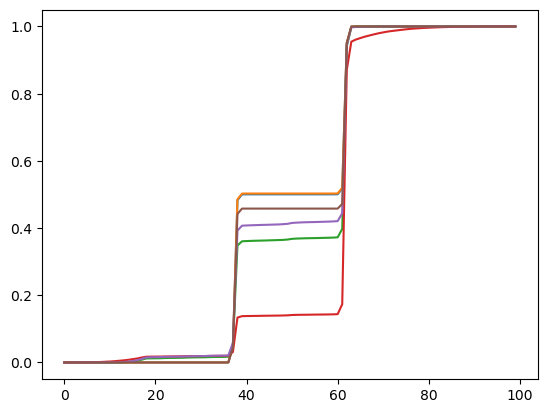

tensor(0.)
tensor(0.0006)
tensor(0.0351)
tensor(0.0946)
tensor(0.0246)
tensor(0.0103)
tensor(0.)
tensor(0.0026)
tensor(0.1396)
tensor(0.3623)
tensor(0.0931)
tensor(0.0456)


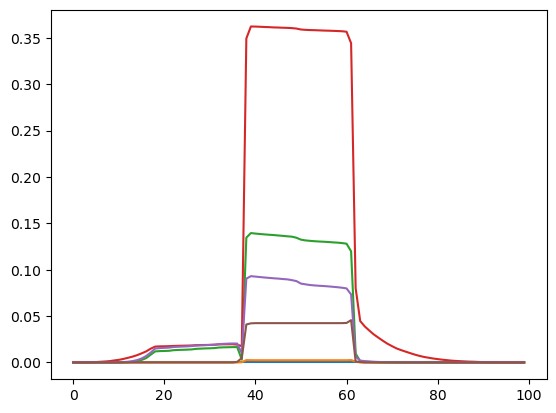

In [26]:
t = torch.linspace(0,1,100)[None]
cdfs = []
for i in range(6):
    cdfs.append((Y0pred[i]<=t).float().mean(0))
    plt.plot(cdfs[i])
plt.show()

for i in range(6):
    print((cdfs[0]-cdfs[i]).abs().mean())

for i in range(6):
    print((cdfs[0]-cdfs[i]).abs().max())

for i in range(6):
    plt.plot((cdfs[0]-cdfs[i]).abs())